# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения

In [1]:
%%capture
!pip install catboost
!pip install phik
!pip install optuna
!pip install -U scikit-learn==1.2.2

In [3]:
#importing all the libraries needed
import numpy as np
import pandas as pd

import re
import phik
import random
import time
from scipy.stats import randint

# import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
%matplotlib inline

pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# import ML packages
import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping
from catboost import CatBoostRegressor
from catboost import Pool, cv
from sklearn.ensemble import RandomForestRegressor
                             
from sklearn.preprocessing import (MinMaxScaler, 
                                   StandardScaler,
                                   OrdinalEncoder, 
                                   OneHotEncoder
                                  )
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import (GridSearchCV,
                                     RandomizedSearchCV,
                                     train_test_split, 
                                     TimeSeriesSplit,
                                     StratifiedKFold,
                                     KFold, 
                                     RepeatedKFold, 
                                     GroupKFold, 
                                     cross_val_score
                                    )

from sklearn.metrics import roc_auc_score, make_scorer, mean_squared_error, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
#warnings.filterwarnings('ignore')

CV = 3

## Подготовка данных

In [4]:
def data_read(df_name):
    try:
        data = pd.read_csv(f'C:\\Users\\m5612\\Downloads\\{df_name}.csv', 
        parse_dates=True)
    except:
        data = pd.read_csv(f'https://code.s3.yandex.net/datasets/{df_name}.csv', 
        parse_dates=True)
    return data

In [5]:
df_full = data_read('autos')
df_full.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Приведение наименований столбцов к общепринятому формату

In [6]:
# Defining a template for renaming columns
pattern = re.compile(r'([a-z])([A-Z])')
new_columns = [pattern.sub(r'\1_\2', column).lower() for column in df_full.columns]

# Renaming columns with the rename() method
df_full.rename(columns=dict(zip(df_full.columns, new_columns)), inplace=True)

## Изучение данных

In [8]:
df_full.sample(3)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
96951,2016-03-05 14:56:57,15500,suv,2010,manual,163,kuga,150000,7,gasoline,ford,no,2016-03-05 00:00:00,0,89613,2016-04-01 16:47:48
249872,2016-03-08 15:50:32,11999,wagon,2009,auto,197,5er,150000,0,gasoline,bmw,no,2016-03-08 00:00:00,0,61348,2016-03-10 23:44:14
271792,2016-03-11 18:37:23,1550,sedan,1997,manual,116,6_reihe,150000,11,petrol,mazda,no,2016-03-11 00:00:00,0,24601,2016-03-16 06:18:44


In [9]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [10]:
df_full.isna().mean().sort_values(ascending=False)

repaired              0.200791
vehicle_type          0.105794
fuel_type             0.092827
gearbox               0.055967
model                 0.055606
date_crawled          0.000000
price                 0.000000
registration_year     0.000000
power                 0.000000
kilometer             0.000000
registration_month    0.000000
brand                 0.000000
date_created          0.000000
number_of_pictures    0.000000
postal_code           0.000000
last_seen             0.000000
dtype: float64

### Проверка на дубликаты

In [11]:
print("Number of duplicates:", df_full.duplicated().sum())

Number of duplicates: 4


In [12]:
df_full.drop_duplicates(inplace=True)

In [13]:
# counting the number of unique values in each column
unique_counts = df_full.nunique()
print(unique_counts)

date_crawled          271174
price                   3731
vehicle_type               8
registration_year        151
gearbox                    2
power                    712
model                    250
kilometer                 13
registration_month        13
fuel_type                  7
brand                     40
repaired                   2
date_created             109
number_of_pictures         1
postal_code             8143
last_seen             179150
dtype: int64


In [14]:
sorted(df_full['model'].dropna().unique())

['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

In [15]:
sorted(df_full['brand'].unique())

['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

### Гистограмма для каждого числового признака

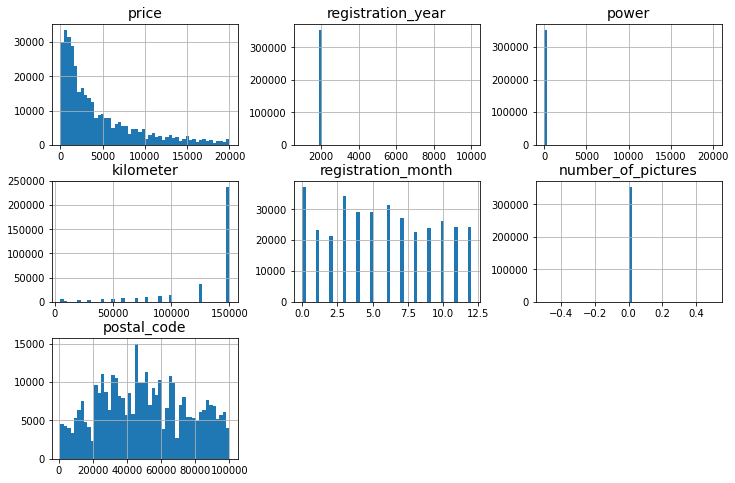

In [16]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df_full.hist(bins=50, figsize=(12, 8))

plt.show()

Данные сильно замусорены

Сделаем копию выборки для изучения

In [17]:
df = df_full.copy()

### Приведение столбцов к типу `date`

In [18]:
# list of columns to cast to date type
date_cols = ['date_crawled', 'date_created', 'last_seen']

# iterate over columns and cast them to date type
for col in date_cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [19]:
#descriptive statistics summary
df.describe(include='all', datetime_is_numeric=True)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
count,354365,354365.000000,316875,354365.000000,334532,354365.000000,334660,354365.000000,354365.000000,321470,354365,283211,354365,354365.0,354365.000000,354365
unique,NaN,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,NaN,NaN,NaN,NaN
top,NaN,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,NaN,NaN,NaN,NaN
freq,NaN,NaN,91457,NaN,268249,NaN,29232,NaN,NaN,216349,77012,247158,NaN,NaN,NaN,NaN
mean,2016-03-21 12:58:09.520460544,4416.679830,NaN,2004.234481,NaN,110.093816,NaN,128211.363989,5.714650,NaN,NaN,NaN,2016-03-20 19:12:06.583042560,0.0,50508.503800,2016-03-29 23:51:06.766184960
min,2016-03-05 14:06:22,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:52
75%,2016-03-29 14:37:20,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,NaN,9999.000000,NaN,20000.000000,NaN,150000.000000,12.000000,NaN,NaN,NaN,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51


### Удалим пустой столбец `number_of_pictures`

In [20]:
df.drop(columns='number_of_pictures', inplace=True)

### Проверка мультиколлинеарности

Используем методы corr() и phik_matrix() для вычисления матрицы корреляции между всеми переменными в датафрейме. Затем визуализируем эту матрицу в виде тепловой карты, используя библиотеку seaborn.

In [21]:
# calculate correlation matrix
corr_matrix = df.corr()
corr_matrix

,price,registration_year,power,kilometer,registration_month,postal_code
price,1.000000,0.026916,0.158872,-0.333207,0.110580,0.076058
registration_year,0.026916,1.000000,-0.000828,-0.053448,-0.011619,-0.003459
power,0.158872,-0.000828,1.000000,0.024006,0.043379,0.021662
kilometer,-0.333207,-0.053448,0.024006,1.000000,0.009575,-0.007685
registration_month,0.110580,-0.011619,0.043379,0.009575,1.000000,0.013996
postal_code,0.076058,-0.003459,0.021662,-0.007685,0.013996,1.000000


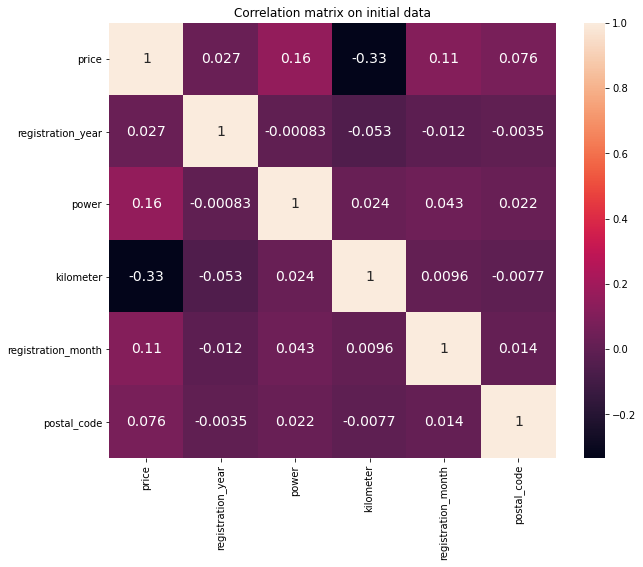

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, ax=ax)
ax.set_title('Correlation matrix on initial data', fontsize=12)
plt.show()

Cильная корреляция между признаками не обнаружена, мультиколлинеарности нет. Если такая корреляция обнаруживается, то можно рассмотреть возможность удаления одной из переменных или использования методов регуляризации для уменьшения мультиколлинеарности.

In [23]:
selected_columns_no_date = df.columns.difference(['date_crawled', 'date_created', 'last_seen'])

In [24]:
df_phik_matrix = df[selected_columns_no_date].phik_matrix()
df_phik_matrix

interval columns not set, guessing: ['kilometer', 'postal_code', 'power', 'price', 'registration_month', 'registration_year']


,brand,fuel_type,gearbox,kilometer,model,postal_code,power,price,registration_month,registration_year,repaired,vehicle_type
brand,1.000000,0.322332,0.520804,0.275096,0.998376,0.181274,0.004459,0.355425,0.109374,0.051203,0.105522,0.633334
fuel_type,0.322332,1.000000,0.151419,0.149132,0.554909,0.050109,0.010882,0.257371,0.057716,0.040116,0.044509,0.330153
gearbox,0.520804,0.151419,1.000000,0.016497,0.647229,0.090839,0.010497,0.323648,0.047190,0.003470,0.043691,0.289225
kilometer,0.275096,0.149132,0.016497,1.000000,0.443426,0.038900,0.000000,0.310847,0.056835,0.230438,0.112939,0.172157
model,0.998376,0.554909,0.647229,0.443426,1.000000,0.221392,0.000000,0.579011,0.150212,0.083359,0.159147,0.917247
postal_code,0.181274,0.050109,0.090839,0.038900,0.221392,1.000000,0.000000,0.096277,0.050179,0.000000,0.017951,0.065342
power,0.004459,0.010882,0.010497,0.000000,0.000000,0.000000,1.000000,0.005752,0.003228,0.088713,0.011678,0.011765
price,0.355425,0.257371,0.323648,0.310847,0.579011,0.096277,0.005752,1.000000,0.185747,0.013889,0.380396,0.268158
registration_month,0.109374,0.057716,0.047190,0.056835,0.150212,0.050179,0.003228,0.185747,1.000000,0.031014,0.138251,0.074605
registration_year,0.051203,0.040116,0.003470,0.230438,0.083359,0.000000,0.088713,0.013889,0.031014,1.000000,0.010072,NaN


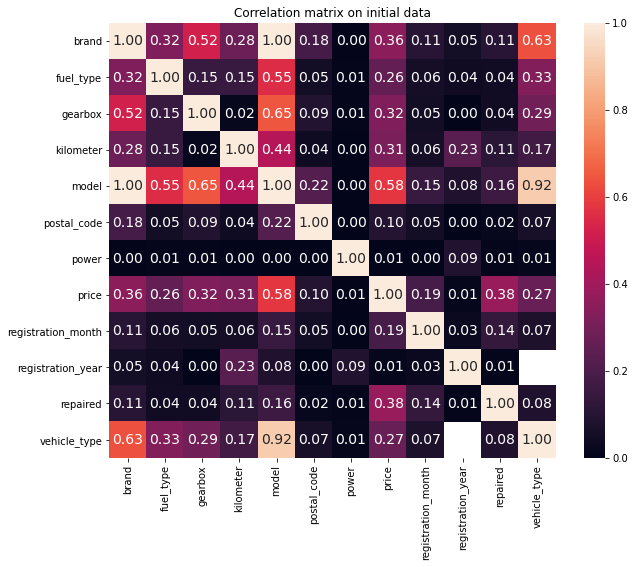

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_phik_matrix, annot=True, fmt='.2f', ax=ax)
ax.set_title('Correlation matrix on initial data', fontsize=12)
plt.show()

Мы видим сильную корреляцию между brand, vehicle_type и model. И неожиданно слабую связь между price и registration_year, power.

brand однозначно привязан к model по типу один ко многим, можно объединить эти два столбца. Между vehicle_type и model более сложная связь многие ко многим и обе фичи сильно влияют на цену.

### Добавим столбец `price_category`

In [26]:
df['price_category'] = pd.qcut(df['price'], q=10)

### Heatmap. Доля nan по ценовой категории

In [27]:
# Alternative option
nan_cols = df.columns[df.isnull().any()].tolist()
nan_cols

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']

In [28]:
df_grouped_price_category = pd.pivot_table(df, values=nan_cols, index='price_category', 
                             aggfunc=lambda x: sum(pd.isnull(x))/len(x))

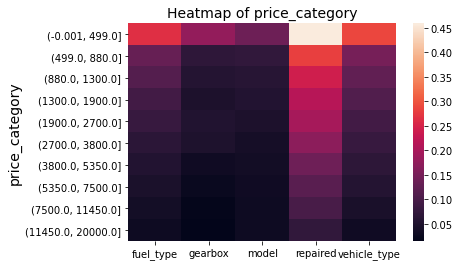

In [29]:
sns.heatmap(df_grouped_price_category)
plt.title("Heatmap of price_category")
plt.show();

Мы видим сильную зависимость качества заполнения анкеты от цены авто. Чем дешевле авто, тем больше пропусков в анкете.

### Заменим пропуски в столбце `model` на значение `other`

In [30]:
print(df['model'].isna().sum())

19705


In [31]:
df['model'] = df['model'].fillna('other')

### Обработка аномалий

#### Признак `price`

In [32]:
def hist_sns(df, title, kde=True):
    sns.displot(df, 
            kde=kde, 
            rug=False, 
            height=3,
            aspect=3)
    plt.title(title)
    plt.show();

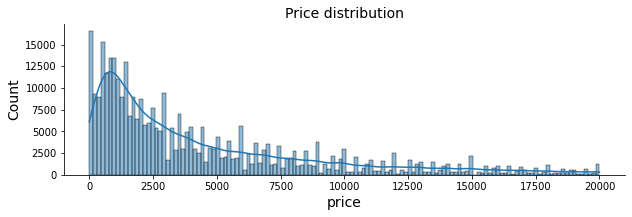

In [33]:
hist_sns(df['price'], 'Price distribution')

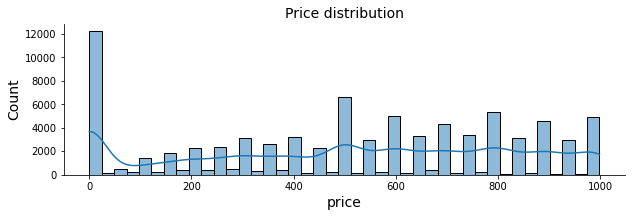

In [34]:
hist_sns(df[df['price'] < 1000]['price'], 'Price distribution')

Мы видим:
- Отклонение от нормального распределения.
- Заметную положительную асимметрию.
- около 5% явно ошибочных значений в районе нуля.
- выборка ограничена авто стоимостью до 20 тысяч.

In [35]:
# Select rows from the 'price' column of the DataFrame where the value is less than 10 and replace them with NaN values.
df.loc[ df['price'] < 10, 'price'] = float('nan')

In [36]:
# Fill in the NaN values in the 'price' column with the median value of the 'price' column grouped by 'brand_model'.
df["price"] = df["price"].fillna(df.groupby(['brand', 'model'])["price"].transform("median"))

In [37]:
df[df['price'].isna()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen,price_category


In [38]:
df.dropna(subset=['price'], inplace=True)

In [39]:
df.shape

(354365, 16)

In [40]:
[col for col in df.columns if df[col].dtype != 'O']

['date_crawled',
 'price',
 'registration_year',
 'power',
 'kilometer',
 'registration_month',
 'date_created',
 'postal_code',
 'last_seen',
 'price_category']

#### Признак `registration_month`

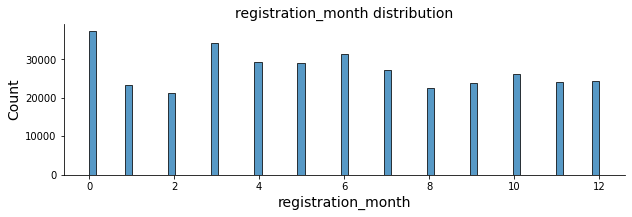

In [41]:
hist_sns(df['registration_month'], 'registration_month distribution', False)

Нули видимо это незаполненные ячейки при заполнении анкеты, то есть пропуски. Заменим пропущенные значения в колонке на случайные месяцы в соответствии с их долей в выборке. 

In [42]:
df.loc[ df['registration_month'] == 0, 'registration_month'] = float('nan')

In [43]:
# calculate the proportions of each month in the sample
month_counts = df['registration_month'].value_counts(normalize=True)
month_counts

3.0     0.108428
6.0     0.099387
4.0     0.092331
5.0     0.091962
7.0     0.085836
10.0    0.082328
12.0    0.076618
11.0    0.076293
9.0     0.075117
1.0     0.073240
8.0     0.071376
2.0     0.067086
Name: registration_month, dtype: float64

In [44]:
# replace missing values with random months weighted by their proportions in the sample
df['registration_month'] = df['registration_month'].apply \
(lambda x: random.choices(month_counts.index, weights=month_counts.values)[0] if pd.isna(x) else x)

In [45]:
# convert float column to int
df['registration_month'] = df['registration_month'].astype(int)

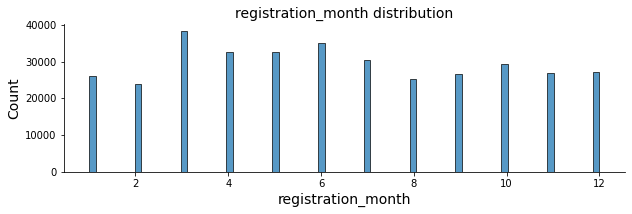

In [46]:
hist_sns(df['registration_month'], 'registration_month distribution', False)

#### Признак `registration_year`

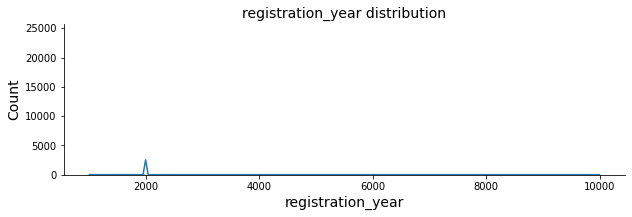

In [47]:
hist_sns(df['registration_year'], 'registration_year distribution')

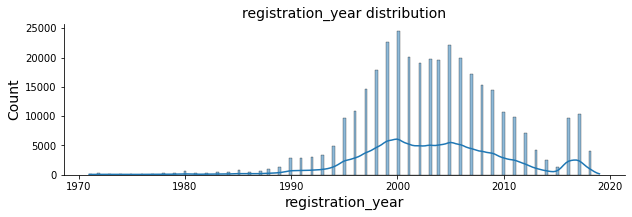

In [48]:
hist_sns(df.loc[(df['registration_year'] < 2020) & (df['registration_year'] > 1970)]['registration_year'], 'registration_year distribution')

Последняя дата выгрузки 2016-04-07, то есть все даты начиная с апреля 2016 явно ошибочно заполнены пользователями. Заполним их медианным значением по модели.

In [49]:
df.loc[(df['registration_year'] > 2016)|(df['registration_year'] < 1970), 'registration_year'] = float('nan')

In [50]:
df.loc[(df['registration_year'] >= 2016) & (df['registration_month'] >= 4), 'registration_year'] = float('nan')

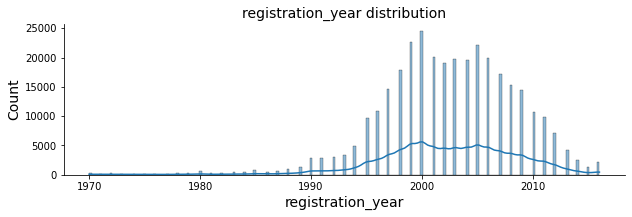

In [51]:
hist_sns(df['registration_year'], 'registration_year distribution')

In [52]:
df["registration_year"] = df["registration_year"].fillna(df.groupby(['brand', 'model'])["registration_year"].transform("median"))

In [53]:
df['registration_year'].isna().sum()

0

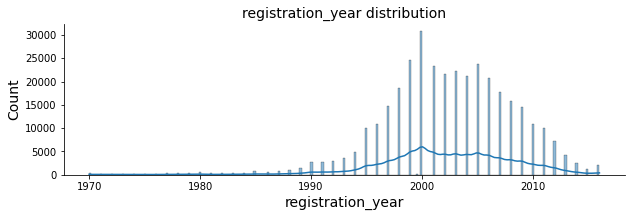

In [54]:
hist_sns(df['registration_year'], 'registration_year distribution')

Мы видим средний срок эксплуатации авто около 15 лет, далее постепенная утилизация.

#### Признак `power`

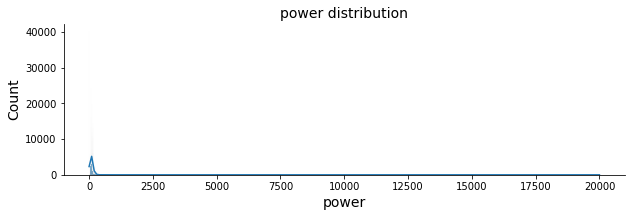

In [55]:
hist_sns(df['power'], 'power distribution')

Заменим на NaN явно ошибочные и аномальные значения более 400 и менее 30:

In [56]:
df.loc[(df['power'] > 400) | (df['power'] < 30), 'power'] = float('nan')

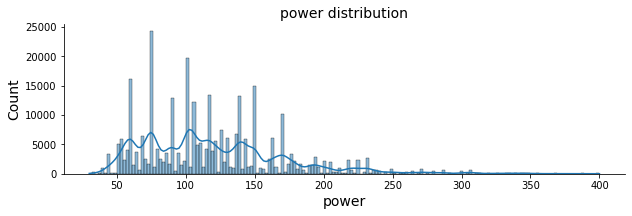

In [57]:
hist_sns(df['power'], 'power distribution')

In [58]:
df["power"] = df["power"].fillna(df.groupby(['brand', 'model'])["power"].transform("median"))
df["power"] = df["power"].fillna(df.groupby(['brand'])["power"].transform("median"))

In [59]:
df['power'].isna().sum()

0

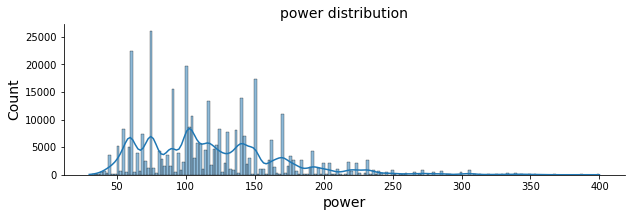

In [60]:
hist_sns(df['power'], 'power distribution')

#### Признак `kilometer`

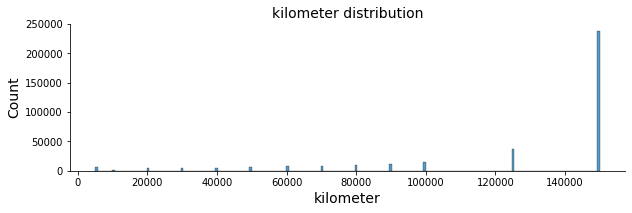

In [61]:
hist_sns(df['kilometer'], 'kilometer distribution', False)

Странные значения, похожи на интервальные, но как есть, аномалии не видны, .

#### Признаки `date_created`, `last_seen` и `date_crawled`

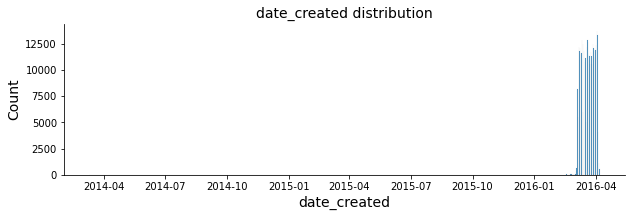

In [62]:
hist_sns(df['date_created'], 'date_created distribution', False)

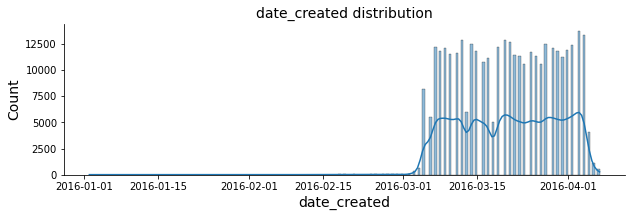

In [63]:
hist_sns(df[(df['date_created'] > '2016-01-01')]['date_created'], 'date_created distribution')

Удалим аномально старые анкеты

In [64]:
df.drop(df[df['date_created'] < '2016-02-20'].index, inplace=True)

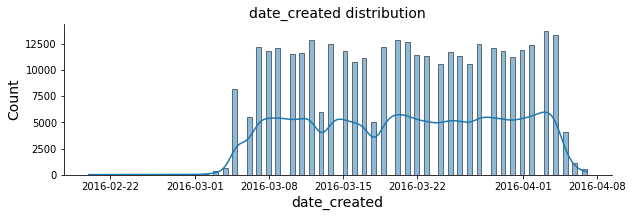

In [65]:
hist_sns(df[(df['date_created'] > '2016-01-01')]['date_created'], 'date_created distribution')

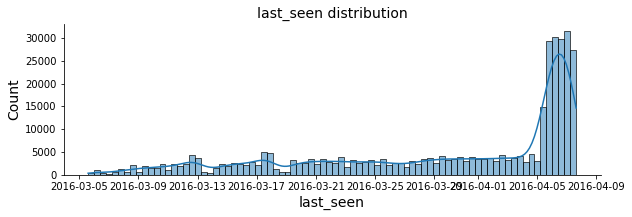

In [66]:
hist_sns(df['last_seen'], 'last_seen distribution')

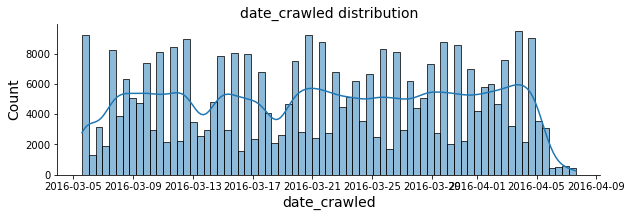

In [67]:
hist_sns(df['date_crawled'], 'date_crawled distribution')

Мы видим 3 провала, вероятно система некоторое время не работала в эти периоды.

#### Признак `postal_code`

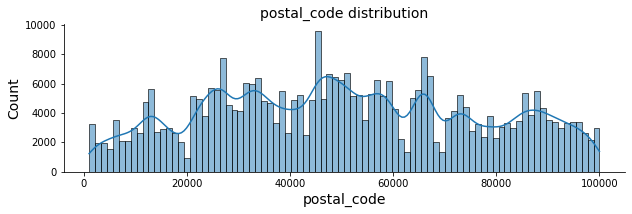

In [68]:
hist_sns(df['postal_code'], 'postal_code distribution')

Очень большое количество категориальных значений

### Пропущенные значения в категориальных признаках

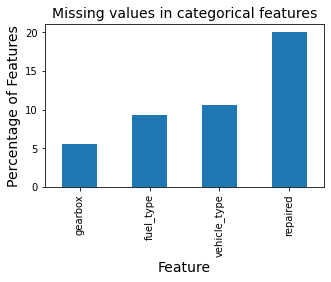

In [69]:
# counting the number of missing values in each column
missing_values = df.isna().mean() * 100
missing_values = missing_values[missing_values > 0].sort_values()
# plotting
missing_values.plot(kind='bar', figsize=(5,3))
plt.title('Missing values in categorical features')
plt.xlabel('Feature')
plt.ylabel('Percentage of Features')
plt.show()

## Анализ целевого признака

### descriptive statistics summary

In [70]:
#descriptive statistics summary
df['price'].describe()

count    354110.000000
mean       4515.305848
std        4462.897794
min          10.000000
25%        1200.000000
50%        2850.000000
75%        6450.000000
max       20000.000000
Name: price, dtype: float64

In [71]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

Skewness: 1.445910
Kurtosis: 1.465524


skew() вычисляет коэффициент асимметрии (skewness) для выборки данных, который показывает, насколько отличается распределение от нормального распределения. Если коэффициент положительный, то распределение смещено вправо (есть больше значений справа от центра).

kurt() вычисляет коэффициент эксцесса (kurtosis) для выборки данных, который показывает, насколько выборка вытянута или сжата относительно нормального распределения. Если коэффициент больше нуля, то распределение более вытянутое (есть больше значений на хвостах распределения).

### Связь с числовыми переменными

In [72]:
def relatio_sc_plot(var_1, var_2, xlim=None, title=None):
    data = pd.concat([df[var_1], df[var_2]], axis=1)
    data = data[data[var_2] > 50]
    ax = data.plot.scatter(x=var_1, 
                      y=var_2, 
                      figsize=(10, 3), 
                      xlim=xlim,
                      alpha=.1,
                      s=5,
                      title=title)

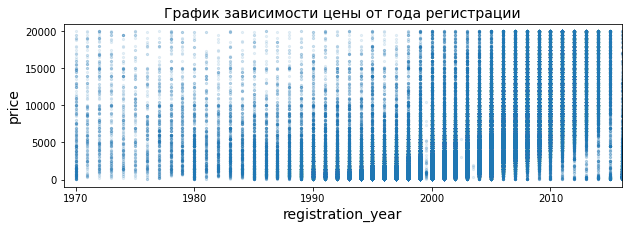

In [73]:
relatio_sc_plot('registration_year', 'price', (1969,2016), 'График зависимости цены от года регистрации')

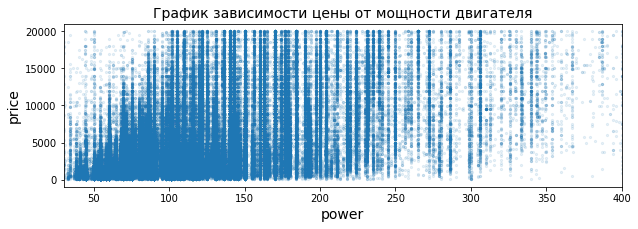

In [74]:
relatio_sc_plot('power', 'price', (30,400), 'График зависимости цены от мощности двигателя')

На обоих графиках мы видим выраженные положительные зависимости

### Связь с датами

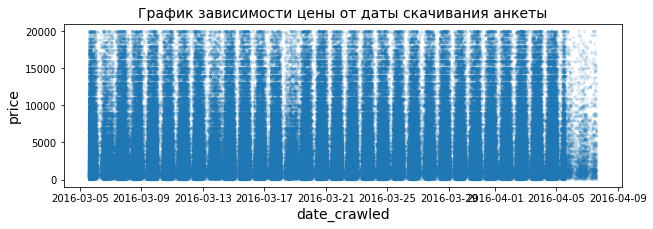

In [75]:
relatio_sc_plot('date_crawled', 'price', None, 'График зависимости цены от даты скачивания анкеты')

In [76]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'postal_code', 'last_seen',
       'price_category'],
      dtype='object')

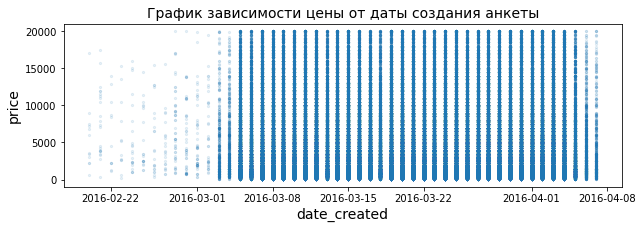

In [77]:
relatio_sc_plot('date_created', 'price', None, 'График зависимости цены от даты создания анкеты')

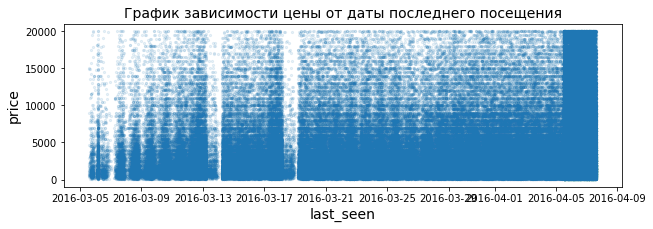

In [78]:
relatio_sc_plot('last_seen', 'price', None, 'График зависимости цены от даты последнего посещения')

Вероятно влияние дат на цену минимально и их можно удалить без потери качества.

### Связь с категориальными признаками

Посмотрим на зависимость цены автомобиля от следующих факторов:

- типа транспортного средства ('vehicle_type');
- типа коробки передач ('gearbox');
- модели автомобиля ('brand_model');
- типа топлива ('fuel_type');
- был ли автомобиль в ремонте ('repaired').

In [79]:
[col for col in df.columns if df[col].dtype == 'O']

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [80]:
def price_boxplot_hist(var_1, var_2, title=None, rotation=0):
    data = pd.concat([df[var_1], df[var_2]], axis=1)
    data = data[data[var_2] > 50]
    
    # заменяем пропущенные значения на новый символ "missing"
    data[var_1] = data[var_1].fillna('missing')

    f, (ax_box, ax_hist) = plt.subplots(2, sharex='col', gridspec_kw={"height_ratios": (.50, .50)}, figsize=(10, 6))

    # boxplot
    sns.boxplot(x=var_1, 
                y=var_2, 
                data=data, 
                ax=ax_box)

    # histogram
    sns.histplot(data=data,
                 x=var_1,
                 ax=ax_hist
                 )
    ax_hist.set_xlabel(var_1)
    
    # добавляем количество наблюдений по каждой категории на гистограмму
    for p in ax_hist.patches:
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax_hist.text(x, y, int(y), ha='center', va='bottom', fontsize=8)    
    
    # добавляем заголовок (если задан)
    if title:
        plt.suptitle(title, fontsize=14)
        
    plt.show()

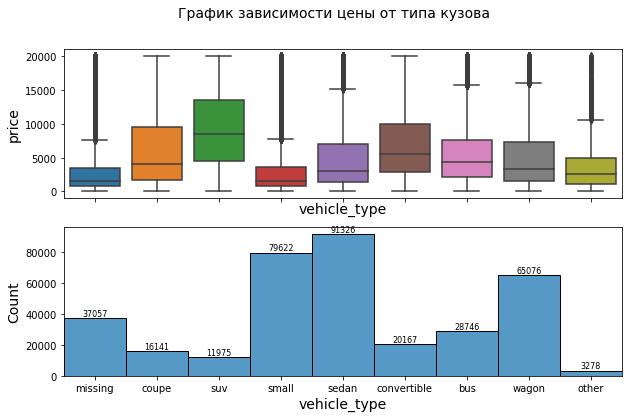

In [81]:
price_boxplot_hist('vehicle_type', 'price', 'График зависимости цены от типа кузова')

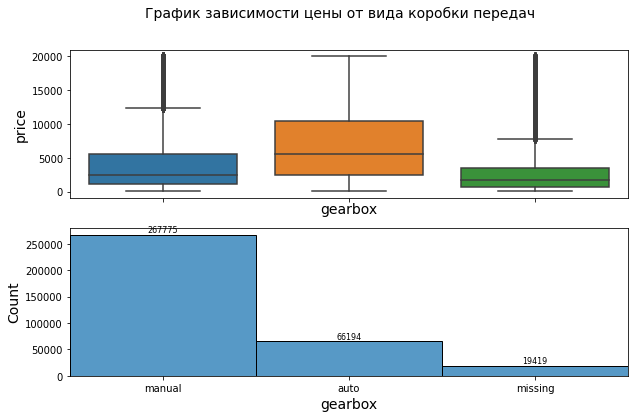

In [82]:
price_boxplot_hist('gearbox', 'price', 'График зависимости цены от вида коробки передач')

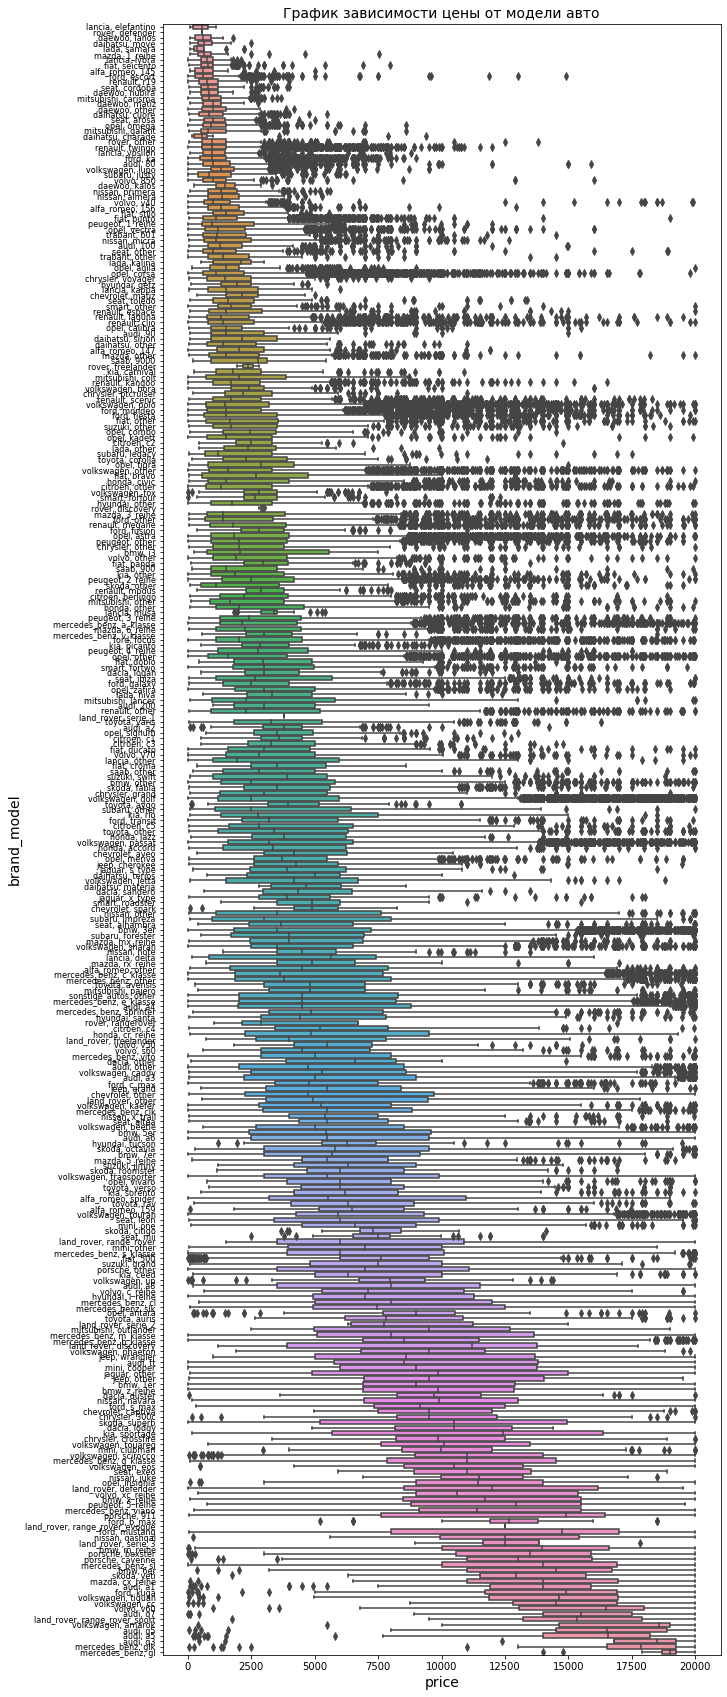

In [83]:
data = df[['brand', 'model', 'price']].copy()
data['brand_model'] = data[['brand', 'model']]. agg(', '.join , axis= 1 )
sorted_mean = list(data.groupby('brand_model').mean().sort_values('price').index)

f, ax = plt.subplots(figsize=(10, 30))
sns.boxplot(x='price', 
            y='brand_model', 
            data=data,
            orient="h",
            order=sorted_mean
)
ax.tick_params(axis='y', labelsize=8)
ax.set_title('График зависимости цены от модели авто')

plt.show()

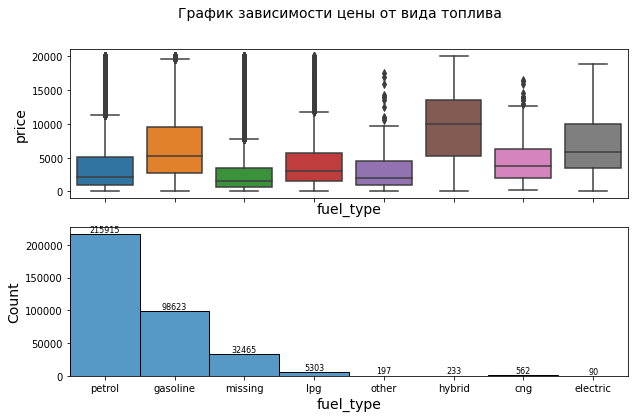

In [84]:
price_boxplot_hist('fuel_type', 'price', 'График зависимости цены от вида топлива')

Описание видов топлива:

- Petrol - Бензин, также известный как газолин, является типом топлива, используемого в двигателях внутреннего сгорания. Он получается из нефти и состоит из смеси углеводородов.

- Gasoline - Газолин является синонимом бензина и используется взаимозаменяемо. В некоторых регионах газолин может относиться специально к типу бензина с более высоким октановым числом или другими специфическими характеристиками.

- LPG - Сжиженный нефтяной газ (СНГ): СНГ - это тип топлива, обычно используемый в отопительных и кухонных приборах, а также в некоторых автомобилях. Он состоит из пропана и бутана, которые сжижаются под давлением. СНГ является более чистым топливом, чем бензин или дизельное топливо, и производит меньше выбросов парниковых газов.

- Other - "Другое" обычно относится к любому типу топлива, который не подходит в другие категории. Это может включать в себя альтернативные топлива, такие как биотопливо, которое получают из возобновляемых источников, таких как растительная масса.

- Hybrid - Гибридные автомобили используют комбинацию бензинового или дизельного двигателя и электромотора для движения автомобиля. Бензиновый или дизельный двигатель используется для привода автомобиля на более высоких скоростях, а электромотор используется на более низких скоростях или когда автомобиль

- CNG - означает сжатый природный газ и является типом топлива, используемого в транспортных средствах. Он состоит из природного газа, который был сжат до высокого давления, что позволяет хранить его в баках в транспортном средстве. CNG является более чистым топливом, чем бензин или дизельное топливо, и выделяет меньше выбросов.

- Electric - Электрические транспортные средства работают на электрических моторах и питаются электричеством, хранящимся в батареях. Они не выделяют выбросов во время движения и становятся все более популярным более чистым и устойчивым альтернативным вариантом автомобилей на бензине и дизельных топливах.

- Отсутствует явно выделенное дизельное топливо в списке.

#### `repaired`

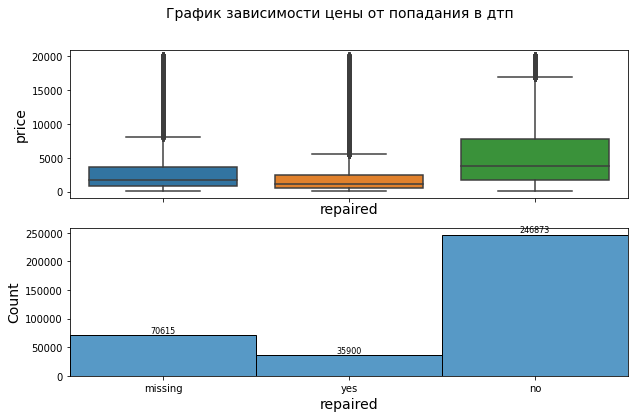

In [85]:
price_boxplot_hist('repaired', 'price', 'График зависимости цены от попадания в дтп')

In [86]:
repaire_df = df[['registration_year','repaired']].copy()

In [87]:
repair_df = pd.pivot_table(repaire_df, index='registration_year', columns='repaired', aggfunc=len, fill_value=1)

In [88]:
repair_df['missing'] = repaire_df['repaired'].isna().groupby(repaire_df['registration_year']).sum()
repair_df.head(2)

repaired,no,yes,missing
registration_year,,,
1970.0,106,21,205
1971.0,107,19,39


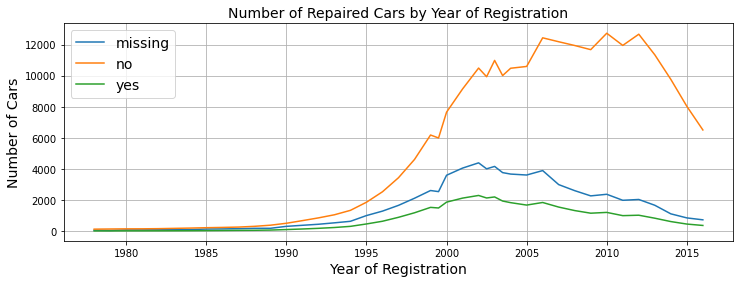

In [89]:
# Создаем график
fig, ax = plt.subplots(figsize=(12, 4))
rol = 9
# Отображаем данные на графике
ax.plot(repair_df.index, repair_df['missing'].rolling(window=rol).mean(), label='missing')
ax.plot(repair_df.index, repair_df['no'].rolling(window=rol).mean(), label='no')
ax.plot(repair_df.index, repair_df['yes'].rolling(window=rol).mean(), label='yes')

# Настраиваем внешний вид графика
ax.set_title('Number of Repaired Cars by Year of Registration')
ax.set_xlabel('Year of Registration')
ax.set_ylabel('Number of Cars')
ax.legend()
ax.grid(True)
# Отображаем график
plt.show()

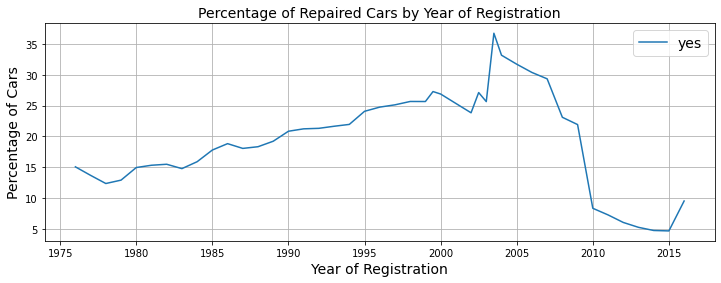

In [90]:
# Создаем график
fig, ax = plt.subplots(figsize=(12, 4))
rol = 7

# Вычисляем доли от 'no' и отображаем их на графике
ax.plot(repair_df.index, (repair_df['yes'] / repair_df['no']).rolling(window=rol).mean() * 100.0, label='yes')

# Настраиваем внешний вид графика
ax.set_title('Percentage of Repaired Cars by Year of Registration')
ax.set_xlabel('Year of Registration')
ax.set_ylabel('Percentage of Cars')
ax.legend()
ax.grid(True)

# Отображаем график
plt.show()

Мы видим ожидаемый рост доли авто побывавших в дтп с повышением их возраста, со второй половины 90-х идет уменьшение доли, вероятно это связано с недоступностью данных за эти годы в базах страховщиков.

### Вывод

- Тип транспортного средства ('vehicle_type') - цена автомобиля варьируеться в зависимости от типа транспортного средства, так как различные типы автомобилей могут иметь разную функциональность, уровень комфорта и способность перевозить грузы.

- Тип коробки передач ('gearbox') - автомобили с автоматической коробкой передач имеют более высокую цену, чем те, у которых механическая коробка передач, из-за удобства использования и комфорта при езде.

- Марка и Модель автомобиля ('brand', 'model') - цена автомобиля варьируеться в зависимости от его модели. Некоторые модели могут быть более престижными или популярными, что может повысить их стоимость. Например, спортивные автомобили имеют более высокие цены, чем среднестатистические автомобили.

- Тип топлива ('fuel_type') - Автомобили, работающие на бензине дешевле, чем те, которые работают на дизеле или газе, гибридные сильно оторвались из-за более сложной конструкции. 

- Был ли автомобиль в ремонте ('repaired') - автомобили, которые были в ремонте из-за дтп, имеют более низкую цену, чем те, которые не были в ремонте.

- Пропуски в анкетах чаще всего у дешевых авто, которые конкурируют с общественным транспортом и особенности машин уже не так важны для владельца. 

## Матрица корреляций на скорректированных данных

In [91]:
selected_columns_no_date = df.columns.difference(['date_crawled', 'date_created', 'last_seen'])

In [92]:
df_phik_matrix_correct = df[selected_columns_no_date].phik_matrix()
df_phik_matrix_correct

interval columns not set, guessing: ['kilometer', 'postal_code', 'power', 'price', 'registration_month', 'registration_year']


,brand,fuel_type,gearbox,kilometer,model,postal_code,power,price,price_category,registration_month,registration_year,repaired,vehicle_type
brand,1.000000,0.322388,0.520743,0.275106,0.997761,0.181376,0.605032,0.371468,0.370350,0.061530,0.371703,0.105622,0.633329
fuel_type,0.322388,1.000000,0.151508,0.149110,0.541036,0.050094,0.262226,0.259060,0.263913,0.041347,0.277319,0.044559,0.330160
gearbox,0.520743,0.151508,1.000000,0.016426,0.632273,0.090720,0.583133,0.328770,0.323850,0.034608,0.125828,0.043606,0.289155
kilometer,0.275106,0.149110,0.016426,1.000000,0.433619,0.038926,0.094910,0.309530,0.308407,0.014477,0.435444,0.112936,0.172151
model,0.997761,0.541036,0.632273,0.433619,1.000000,0.216064,0.826213,0.582741,0.578680,0.107457,0.662324,0.163751,0.910504
postal_code,0.181376,0.050094,0.090720,0.038926,0.216064,1.000000,0.088156,0.093047,0.107161,0.028233,0.083679,0.018001,0.065356
power,0.605032,0.262226,0.583133,0.094910,0.826213,0.088156,1.000000,0.517098,0.513376,0.036387,0.281059,0.093607,0.503840
price,0.371468,0.259060,0.328770,0.309530,0.582741,0.093047,0.517098,1.000000,0.948322,0.027688,0.668800,0.368128,0.272762
price_category,0.370350,0.263913,0.323850,0.308407,0.578680,0.107161,0.513376,0.948322,1.000000,0.036442,0.682424,0.497490,0.276082
registration_month,0.061530,0.041347,0.034608,0.014477,0.107457,0.028233,0.036387,0.027688,0.036442,1.000000,0.098281,0.018931,0.063392


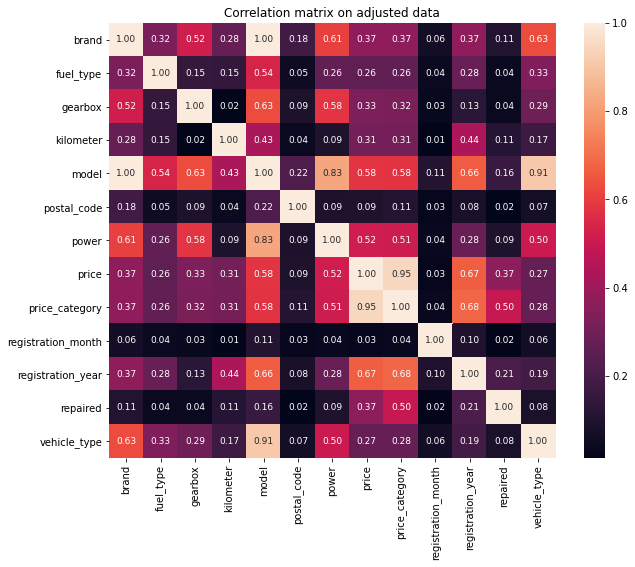

In [93]:
# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(10, 8))

# Рисуем heatmap
sns.heatmap(df_phik_matrix_correct, annot=True, fmt='.2f', annot_kws={"fontsize":9}, ax=ax)

# Добавляем заголовок
ax.set_title('Correlation matrix on adjusted data', fontsize=12)

# Отображаем график
plt.show()

График стал куда более адекватным.

У нас появилась логичная сильная зависимость между price и registration_year, power, brand, model.

## Pipeline предобработки датасета

### Выделим тренировочную, валидационную и тестовоую выборки

In [187]:
# Разбиваем данные на обучающую и валидационную выборки в пропорции 70:30
df_train_valid, df_test = train_test_split(df_full, test_size=0.2, random_state=42)
df_train, df_valid = train_test_split(df_train_valid, test_size=0.25, random_state=42)
print(f"Размер обучающей выборки: {len(df_train)}")
print(f"Размер валидационной выборки: {len(df_valid)}")
print(f"Размер тестовой выборки: {len(df_test)}")

Размер обучающей выборки: 212619
Размер валидационной выборки: 70873
Размер тестовой выборки: 70873


### Выделим признаки и таргет

In [188]:
X_train = df_train.drop("price", axis=1)
y_train = df_train["price"].copy()
X_valid = df_valid.drop("price", axis=1)
y_valid = df_valid["price"].copy()
X_test = df_test.drop("price", axis=1)
y_test = df_test["price"].copy()

print("Training Features:\n", X_train.shape)
print("\nTraining Target:\n", y_train.shape)
print("\nValidation Features:\n", X_valid.shape)
print("\nValidation Target:\n", y_valid.shape)

Training Features:
 (212619, 15)

Training Target:
 (212619,)

Validation Features:
 (70873, 15)

Validation Target:
 (70873,)


### Pipeline обработки пропущенных значений и аномалий
Мы не будем использовать в обучении столбцы:'number_of_pictures', 'date_crawled', 'date_created', 'last_seen','registration_month', 'postal_code'. Они очень слабо влияют на наш таргет.
Напишем pipepline обработки аномалий и пропущенных значений.

In [189]:
# Define a list of categorical and numerical features
num_features = ['registration_year', 'power', 'kilometer']
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [190]:
# Let's create a custom converter based on our function
class Custom_Missing_Delete_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self): #, is_cat):
        #self.is_cat = is_cat
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        def anomaly_processing_base(df):
            df['model'] = df['model'].fillna('other')   
            # registration_year
            df.loc[(df['registration_year'] > 2016)|(df['registration_year'] < 1970), 'registration_year'] = float('nan')
            df.loc[(df['registration_year'] >= 2016) & (df['registration_month'] >= 4), 'registration_year'] = float('nan')
            # power
            df.loc[(df['power'] > 400) | (df['power'] < 30), 'power'] = float('nan')
            df.drop(columns=['number_of_pictures', 'date_crawled', 'date_created', \
                         'last_seen', 'registration_month', 'postal_code'], inplace=True)
            return df

        def fill_missing_values_num(df):
            num_list = df.select_dtypes(exclude='object').columns.to_list()
            # replace missing values with random months weighted by their proportions in the sample
            df["registration_year"] = df["registration_year"].fillna(df.groupby(['brand', 'model'])["registration_year"].transform("median"))
            df["power"] = df["power"].fillna(df.groupby(['brand', 'model'])["power"].transform("median"))
            df[num_list] = df[num_list].fillna(df[num_list].median())
            return df

        def fill_missing_values_cat(df):
            imputer_freq = SimpleImputer(strategy="most_frequent", keep_empty_features=True)
            imputer_other = SimpleImputer(strategy="constant", fill_value = 'other')
            grouped = df.groupby(['brand', 'model'])
            for name, group in grouped:
                #display(name, group)
                if group.shape[0] == 1:
                    group_imputed = pd.DataFrame(imputer_other.fit_transform(group[['vehicle_type', 'gearbox', 'fuel_type']]), \
                                              columns=['vehicle_type', 'gearbox', 'fuel_type'], index=group.index) 
                else:
                # заполнение пропущенных значений в столбцах 'vehicle_type', 'gearbox', и 'fuel_type'
                    group_imputed = pd.DataFrame(imputer_freq.fit_transform(group[['vehicle_type', 'gearbox', 'fuel_type']]), \
                                                 columns=['vehicle_type', 'gearbox', 'fuel_type'], index=group.index)
                # обновление соответствующих столбцов в DataFrame df
                df.update(group_imputed)
            df['repaired'] = df['repaired'].fillna('other')
            return df

        def pipe_missing_delete(df):
            anomaly_processing_base(df)
            fill_missing_values_num(df)
            fill_missing_values_cat(df)
            return df

        X_transformed = pipe_missing_delete(X) #, self.is_cat)
        return X_transformed

In [191]:
%%time
pipe_missing_delete = Pipeline([
    ('missing_delete', Custom_Missing_Delete_Transformer())
])

X_train_no_miss = pipe_missing_delete.fit_transform(X_train.copy())

CPU times: user 38.6 s, sys: 147 ms, total: 38.8 s
Wall time: 39.9 s


In [192]:
X_train_no_miss.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
11659,small,1996.0,manual,60.0,polo,125000,petrol,volkswagen,no
261973,sedan,1997.0,manual,90.0,escort,150000,petrol,ford,other
328500,wagon,2005.0,manual,116.0,astra,150000,petrol,opel,other
65130,small,2003.0,manual,64.0,polo,150000,petrol,volkswagen,no
235185,sedan,2009.0,manual,90.0,a3,150000,gasoline,audi,no


In [193]:
X_valid_no_miss = pipe_missing_delete.transform(X_valid.copy())

In [194]:
X_test_no_miss = pipe_missing_delete.transform(X_test.copy())

In [195]:
X_valid_no_miss.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
204726,small,2015.0,manual,72.0,other,40000,petrol,mitsubishi,no
175072,suv,1996.0,auto,215.0,grand,150000,lpg,jeep,no
43982,sedan,1992.0,manual,75.0,other,150000,gasoline,mercedes_benz,no
9757,sedan,2007.0,manual,170.0,c_klasse,150000,gasoline,mercedes_benz,no
333826,wagon,2006.0,manual,163.0,3er,150000,gasoline,bmw,no


In [196]:
X_train_no_miss.isna().sum().sum()

0

In [197]:
X_valid_no_miss.isna().sum().sum()

0

### Pipeline One-Hot Encoding

In [198]:
col_transformer_ohe = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Apply preprocessor to training data and get features
X_train_prepared_ohe = col_transformer_ohe.fit_transform(X_train_no_miss)
X_test_prepared_ohe = col_transformer_ohe.transform(X_test_no_miss)

In [199]:
old_index = X_train_no_miss.index
new_column_names = col_transformer_ohe.get_feature_names_out()

In [200]:
X_train_prepared_ohe_df = pd.DataFrame(X_train_prepared_ohe.toarray(), columns=new_column_names, index = old_index)

In [201]:
X_train_prepared_ohe_df.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,...,model_ypsilon,model_z_reihe,model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_other,repaired_yes
11659,-1.036556,-1.145411,-0.085318,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
261973,-0.874009,-0.559715,0.574876,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
328500,0.426370,-0.052112,0.574876,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
65130,0.101275,-1.067318,0.574876,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
235185,1.076560,-0.559715,0.574876,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pipeline OrdinalEncoder

In [202]:
col_transformer_ord = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('ordinal', OrdinalEncoder(dtype=np.int16, handle_unknown='use_encoded_value', unknown_value= -1, encoded_missing_value=-1), cat_features)],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Apply preprocessor to training data and get features
X_train_prepared_ord = col_transformer_ord.fit_transform(X_train_no_miss)

In [203]:
new_column_names = col_transformer_ord.get_feature_names_out()
X_train_prepared_ord_df = pd.DataFrame(X_train_prepared_ord, columns=new_column_names, index=X_train_no_miss.index)

In [204]:
X_train_prepared_ord_df.head()

,registration_year,power,kilometer,vehicle_type,gearbox,model,fuel_type,brand,repaired
11659,-1.036556,-1.145411,-0.085318,5.0,1.0,173.0,6.0,38.0,0.0
261973,-0.874009,-0.559715,0.574876,4.0,1.0,98.0,6.0,10.0,1.0
328500,0.426370,-0.052112,0.574876,7.0,1.0,42.0,6.0,24.0,1.0
65130,0.101275,-1.067318,0.574876,5.0,1.0,173.0,6.0,38.0,0.0
235185,1.076560,-0.559715,0.574876,4.0,1.0,28.0,2.0,1.0,0.0


In [205]:
X_train_prepared_ord_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212619 entries, 11659 to 102791
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   registration_year  212619 non-null  float64
 1   power              212619 non-null  float64
 2   kilometer          212619 non-null  float64
 3   vehicle_type       212619 non-null  float64
 4   gearbox            212619 non-null  float64
 5   model              212619 non-null  float64
 6   fuel_type          212619 non-null  float64
 7   brand              212619 non-null  float64
 8   repaired           212619 non-null  float64
dtypes: float64(9)
memory usage: 16.2 MB


In [206]:
X_test_prepared_ord = col_transformer_ord.transform(X_test_no_miss)

In [207]:
X_valid_prepared_ord = col_transformer_ord.transform(X_valid_no_miss)

## Обучение моделей

создадим функцию сбора результатов испытаний в датафрейм

In [208]:
df_model_results = pd.DataFrame(columns=['model', 'optimizer', 'fit_time', 'predict_time', 'RMSE', 'best_params'])

def add_results(model, optimizer, fit_time, predict_time, RMSE, best_params):
    global df_model_results
    df_model_results = df_model_results.append({'model': model,
                        'optimizer': optimizer,
                        'fit_time': fit_time,
                        'predict_time': predict_time,
                        'RMSE': abs(RMSE),
                        'best_params': best_params    
                        }, ignore_index=True)

### LinearRegression

In [209]:
%%time
model = LinearRegression()

pipeline_lr = make_pipeline(col_transformer_ohe, model)

param_grid_lr = {
    'linearregression__fit_intercept': [True, False]
}

study = GridSearchCV(
    pipeline_lr, 
    param_grid=param_grid_lr, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=4,
    cv=CV
)

start_time = time.time()
study.fit(X_train_no_miss, y_train)
fit_time = round(time.time() - start_time, 4)

# лучшее значение RMSE на кросс-валидации
print(f'best_score: {abs(study.best_score_)}')
# лучшие гиперпараметры
print(f'best_params: {study.best_params_}')

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


best_score: 2704.5649014463975
best_params: {'linearregression__fit_intercept': True}
CPU times: user 15.5 s, sys: 16.3 s, total: 31.8 s
Wall time: 54.3 s


In [210]:
start_time = time.time()
preds = study.predict(X_valid_no_miss)
predict_time = round(time.time() - start_time, 4)
predict_time

0.3148

In [211]:
add_results('LinearRegression', 'GridSearchCV', fit_time, 
            predict_time, study.best_score_, study.best_params_)

In [212]:
df_model_results

,model,optimizer,fit_time,predict_time,RMSE,best_params
0,LinearRegression,GridSearchCV,54.3429,0.3148,2704.564901,{'linearregression__fit_intercept': True}


### RandomForestRegressor

In [213]:
%%time
# Define the objective function for Optuna
def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 2, 120, log=True),
    'max_depth': trial.suggest_int('max_depth', 2, 32),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15, log=True)
    }
    
    rf_regressor = RandomForestRegressor(**params, random_state=42)
    
    rf_regressor.fit(X_train_prepared_ord,y_train)
    
    y_pred = rf_regressor.predict(X_valid_prepared_ord)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    return rmse

# Run Optuna to find the best hyperparameters
study = optuna.create_study(direction='minimize')

start_time = time.time()
study.optimize(objective, n_trials=10)
fit_time = round(time.time() - start_time, 4)

# Print the best hyperparameters and RMSE
best_params = study.best_params
best_rmse = study.best_value
print(f"Best hyperparameters: {best_params}")
print(f"Best RMSE: {best_rmse:.2f}")

[I 2023-04-05 12:05:31,880] A new study created in memory with name: no-name-036cfea0-51f4-492b-b1ec-97580cba4506
[I 2023-04-05 12:05:49,524] Trial 0 finished with value: 1904.2949686383743 and parameters: {'n_estimators': 48, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 1904.2949686383743.
[I 2023-04-05 12:05:54,785] Trial 1 finished with value: 1910.5991707668159 and parameters: {'n_estimators': 13, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 14}. Best is trial 0 with value: 1904.2949686383743.
[I 2023-04-05 12:05:55,647] Trial 2 finished with value: 2014.101609752442 and parameters: {'n_estimators': 2, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 1904.2949686383743.
[I 2023-04-05 12:06:12,015] Trial 3 finished with value: 1845.0681881309097 and parameters: {'n_estimators': 34, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 3 with value: 184

Best hyperparameters: {'n_estimators': 34, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 5}
Best RMSE: 1845.07
CPU times: user 46.1 s, sys: 120 ms, total: 46.2 s
Wall time: 47.3 s


In [214]:
optuna.visualization.plot_param_importances(study)

In [215]:
%%time
# Use the best hyperparameters to train a final model
final_model =  RandomForestRegressor(**best_params, random_state=42)
final_model.fit(X_train_prepared_ord, y_train)
start_time = time.time()
y_pred = final_model.predict(X_valid_prepared_ord)
predict_time = round(time.time() - start_time, 4)
# Calculate the RMSE of the predictions
test_rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f"RMSE: {test_rmse:.2f}")

RMSE: 1845.07
CPU times: user 15.3 s, sys: 54.7 ms, total: 15.4 s
Wall time: 15.4 s


In [216]:
add_results('RandomForestRegressor', 'Optuna', fit_time, 
            predict_time, study.best_value, study.best_params)

In [217]:
df_model_results

,model,optimizer,fit_time,predict_time,RMSE,best_params
0,LinearRegression,GridSearchCV,54.3429,0.3148,2704.564901,{'linearregression__fit_intercept': True}
1,RandomForestRegressor,Optuna,47.3184,0.5392,1845.068188,"{'n_estimators': 34, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 5}"


### LGBM

In [218]:
# Creating an instance of LGBMRegressor
lgbm = LGBMRegressor()

####  Optuna

In [219]:
%%time

# Define the objective function to be minimized by Optuna
def objective(trial):
    # Define the hyperparameters to be tuned
    params = {
        'metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, step=0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000, step=50),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0, step=0.1),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 30),
        'random_state': 42,
        'n_jobs': 4
    }

    # Create the LGBMRegressor model with the sampled hyperparameters
    model = LGBMRegressor(**params)

    # Fit the model to the training data
    model.fit(X_train_prepared_ord,
              y_train, 
              eval_set=[(X_valid_prepared_ord, y_valid)],
              )
        
    # Use the trained model to predict on the testing data
    y_pred = model.predict(X_valid_prepared_ord)

    
    # Calculate the RMSE on the testing data
    rmse = mean_squared_error(y_valid, y_pred, squared=False)

    # Return the RMSE as the objective value to be minimized by Optuna
    return rmse

# Create the Optuna study and run the optimization
study = optuna.create_study(direction='minimize')

start_time = time.time()
study.optimize(objective, n_trials=20, timeout=300)
fit_time = round(time.time() - start_time, 4)

[I 2023-04-05 12:06:34,876] A new study created in memory with name: no-name-40401670-3158-4110-b2a9-b869413a362c


[1]	valid_0's rmse: 3921.38
[2]	valid_0's rmse: 3466.07
[3]	valid_0's rmse: 3124.12
[4]	valid_0's rmse: 2878.45
[5]	valid_0's rmse: 2691.48
[6]	valid_0's rmse: 2550.49
[7]	valid_0's rmse: 2445.56
[8]	valid_0's rmse: 2362.47
[9]	valid_0's rmse: 2294.73
[10]	valid_0's rmse: 2243.37
[11]	valid_0's rmse: 2203.69
[12]	valid_0's rmse: 2166.66
[13]	valid_0's rmse: 2140.76
[14]	valid_0's rmse: 2110.95
[15]	valid_0's rmse: 2093.66
[16]	valid_0's rmse: 2077.83
[17]	valid_0's rmse: 2065.57
[18]	valid_0's rmse: 2051.9
[19]	valid_0's rmse: 2044.02
[20]	valid_0's rmse: 2032.02
[21]	valid_0's rmse: 2023.62
[22]	valid_0's rmse: 2014.38
[23]	valid_0's rmse: 2005.85
[24]	valid_0's rmse: 2000.32
[25]	valid_0's rmse: 1994.76
[26]	valid_0's rmse: 1988.93
[27]	valid_0's rmse: 1984.21
[28]	valid_0's rmse: 1981.05
[29]	valid_0's rmse: 1977.51
[30]	valid_0's rmse: 1973.63
[31]	valid_0's rmse: 1969.49
[32]	valid_0's rmse: 1967.64
[33]	valid_0's rmse: 1964.39
[34]	valid_0's rmse: 1961.84
[35]	valid_0's rmse: 195

[I 2023-04-05 12:07:00,166] Trial 0 finished with value: 1793.093074927927 and parameters: {'learning_rate': 0.2, 'n_estimators': 600, 'colsample_bytree': 1.0, 'min_child_samples': 27}. Best is trial 0 with value: 1793.093074927927.


[1]	valid_0's rmse: 4068.49
[2]	valid_0's rmse: 2952.92
[3]	valid_0's rmse: 2470.47
[4]	valid_0's rmse: 2389.4
[5]	valid_0's rmse: 2304.76
[6]	valid_0's rmse: 2278.02
[7]	valid_0's rmse: 2242.15
[8]	valid_0's rmse: 2220.63
[9]	valid_0's rmse: 2200.88
[10]	valid_0's rmse: 2145.95
[11]	valid_0's rmse: 2126.59
[12]	valid_0's rmse: 2124.66
[13]	valid_0's rmse: 2121.83
[14]	valid_0's rmse: 2116.93
[15]	valid_0's rmse: 2097.91
[16]	valid_0's rmse: 2094.16
[17]	valid_0's rmse: 2058.71
[18]	valid_0's rmse: 2041.9
[19]	valid_0's rmse: 2032.67
[20]	valid_0's rmse: 2023.66
[21]	valid_0's rmse: 2018.11
[22]	valid_0's rmse: 2010.19
[23]	valid_0's rmse: 2007.01
[24]	valid_0's rmse: 1997.84
[25]	valid_0's rmse: 1990.73
[26]	valid_0's rmse: 1984.2
[27]	valid_0's rmse: 1980.74
[28]	valid_0's rmse: 1978.97
[29]	valid_0's rmse: 1976
[30]	valid_0's rmse: 1971.56
[31]	valid_0's rmse: 1965.28
[32]	valid_0's rmse: 1964.73
[33]	valid_0's rmse: 1961.37
[34]	valid_0's rmse: 1959.38
[35]	valid_0's rmse: 1957.96


[I 2023-04-05 12:07:23,588] Trial 1 finished with value: 1847.3157035182735 and parameters: {'learning_rate': 0.6, 'n_estimators': 450, 'colsample_bytree': 0.30000000000000004, 'min_child_samples': 13}. Best is trial 0 with value: 1793.093074927927.


[1]	valid_0's rmse: 4068.49
[2]	valid_0's rmse: 2952.92
[3]	valid_0's rmse: 2470.47
[4]	valid_0's rmse: 2389.4
[5]	valid_0's rmse: 2304.76
[6]	valid_0's rmse: 2277.95
[7]	valid_0's rmse: 2242.06
[8]	valid_0's rmse: 2220.53
[9]	valid_0's rmse: 2200.95
[10]	valid_0's rmse: 2146.27
[11]	valid_0's rmse: 2127.17
[12]	valid_0's rmse: 2125.37
[13]	valid_0's rmse: 2123.75
[14]	valid_0's rmse: 2118.72
[15]	valid_0's rmse: 2100.95
[16]	valid_0's rmse: 2097.73
[17]	valid_0's rmse: 2064.04
[18]	valid_0's rmse: 2046.43
[19]	valid_0's rmse: 2038.41
[20]	valid_0's rmse: 2028.77
[21]	valid_0's rmse: 2021.9
[22]	valid_0's rmse: 2012.05
[23]	valid_0's rmse: 2008.02
[24]	valid_0's rmse: 1999.65
[25]	valid_0's rmse: 1991.82
[26]	valid_0's rmse: 1986.09
[27]	valid_0's rmse: 1981.39
[28]	valid_0's rmse: 1979.28
[29]	valid_0's rmse: 1974.9
[30]	valid_0's rmse: 1970.14
[31]	valid_0's rmse: 1964.43
[32]	valid_0's rmse: 1959.99
[33]	valid_0's rmse: 1958.3
[34]	valid_0's rmse: 1956.39
[35]	valid_0's rmse: 1955.3

[I 2023-04-05 12:07:29,662] Trial 2 finished with value: 1892.004224175959 and parameters: {'learning_rate': 0.6, 'n_estimators': 100, 'colsample_bytree': 0.30000000000000004, 'min_child_samples': 21}. Best is trial 0 with value: 1793.093074927927.


[100]	valid_0's rmse: 1892
[1]	valid_0's rmse: 3095.04
[2]	valid_0's rmse: 2468.48
[3]	valid_0's rmse: 2345.69
[4]	valid_0's rmse: 2279.11
[5]	valid_0's rmse: 2245.04
[6]	valid_0's rmse: 2210.28
[7]	valid_0's rmse: 2169.55
[8]	valid_0's rmse: 2124.17
[9]	valid_0's rmse: 2100.34
[10]	valid_0's rmse: 2089.13
[11]	valid_0's rmse: 2071.97
[12]	valid_0's rmse: 2053.5
[13]	valid_0's rmse: 2043.26
[14]	valid_0's rmse: 2039.62
[15]	valid_0's rmse: 2011.1
[16]	valid_0's rmse: 2004.78
[17]	valid_0's rmse: 1998.4
[18]	valid_0's rmse: 1993.05
[19]	valid_0's rmse: 1984.33
[20]	valid_0's rmse: 1981.04
[21]	valid_0's rmse: 1977.96
[22]	valid_0's rmse: 1973.86
[23]	valid_0's rmse: 1968.82
[24]	valid_0's rmse: 1965.25
[25]	valid_0's rmse: 1961
[26]	valid_0's rmse: 1958.56
[27]	valid_0's rmse: 1953.41
[28]	valid_0's rmse: 1952.52
[29]	valid_0's rmse: 1950.92
[30]	valid_0's rmse: 1947.43
[31]	valid_0's rmse: 1944.75
[32]	valid_0's rmse: 1944.49
[33]	valid_0's rmse: 1942.53
[34]	valid_0's rmse: 1939.51
[3

[I 2023-04-05 12:08:20,556] Trial 3 finished with value: 1874.9342766489767 and parameters: {'learning_rate': 0.8, 'n_estimators': 1000, 'colsample_bytree': 0.5, 'min_child_samples': 29}. Best is trial 0 with value: 1793.093074927927.


[1]	valid_0's rmse: 4278.29
[2]	valid_0's rmse: 3998.21
[3]	valid_0's rmse: 3752.94
[4]	valid_0's rmse: 3541.13
[5]	valid_0's rmse: 3355.66
[6]	valid_0's rmse: 3226.62
[7]	valid_0's rmse: 3086.89
[8]	valid_0's rmse: 3008.94
[9]	valid_0's rmse: 2886.53
[10]	valid_0's rmse: 2780.85
[11]	valid_0's rmse: 2695.54
[12]	valid_0's rmse: 2615.45
[13]	valid_0's rmse: 2551.91
[14]	valid_0's rmse: 2490.62
[15]	valid_0's rmse: 2442.27
[16]	valid_0's rmse: 2406.14
[17]	valid_0's rmse: 2368.05
[18]	valid_0's rmse: 2332.19
[19]	valid_0's rmse: 2299.17
[20]	valid_0's rmse: 2272.14
[21]	valid_0's rmse: 2249.54
[22]	valid_0's rmse: 2220.66
[23]	valid_0's rmse: 2202.45
[24]	valid_0's rmse: 2179.26
[25]	valid_0's rmse: 2160.14
[26]	valid_0's rmse: 2147.29
[27]	valid_0's rmse: 2136.29
[28]	valid_0's rmse: 2126.92
[29]	valid_0's rmse: 2114.03
[30]	valid_0's rmse: 2105.59
[31]	valid_0's rmse: 2094.24
[32]	valid_0's rmse: 2085.93
[33]	valid_0's rmse: 2075.56
[34]	valid_0's rmse: 2068.06
[35]	valid_0's rmse: 20

[I 2023-04-05 12:09:03,092] Trial 4 finished with value: 1816.8205706807018 and parameters: {'learning_rate': 0.1, 'n_estimators': 600, 'colsample_bytree': 0.6, 'min_child_samples': 19}. Best is trial 0 with value: 1793.093074927927.


[1]	valid_0's rmse: 4215.97
[2]	valid_0's rmse: 3947.97
[3]	valid_0's rmse: 3712.78
[4]	valid_0's rmse: 3510.03
[5]	valid_0's rmse: 3329.84
[6]	valid_0's rmse: 3176.16
[7]	valid_0's rmse: 3039.82
[8]	valid_0's rmse: 2922.45
[9]	valid_0's rmse: 2820.14
[10]	valid_0's rmse: 2731.1
[11]	valid_0's rmse: 2652.53
[12]	valid_0's rmse: 2586.54
[13]	valid_0's rmse: 2527.47
[14]	valid_0's rmse: 2474.68
[15]	valid_0's rmse: 2427.28
[16]	valid_0's rmse: 2386.78
[17]	valid_0's rmse: 2350.19
[18]	valid_0's rmse: 2319.26
[19]	valid_0's rmse: 2291.38
[20]	valid_0's rmse: 2261.83
[21]	valid_0's rmse: 2239.52
[22]	valid_0's rmse: 2217.14
[23]	valid_0's rmse: 2195.98
[24]	valid_0's rmse: 2176.49
[25]	valid_0's rmse: 2161.76
[26]	valid_0's rmse: 2147.71
[27]	valid_0's rmse: 2135.06
[28]	valid_0's rmse: 2123.66
[29]	valid_0's rmse: 2112.09
[30]	valid_0's rmse: 2103.22
[31]	valid_0's rmse: 2093.52
[32]	valid_0's rmse: 2084.1
[33]	valid_0's rmse: 2075.37
[34]	valid_0's rmse: 2068.69
[35]	valid_0's rmse: 2062

[I 2023-04-05 12:09:21,086] Trial 5 finished with value: 1865.6272849882107 and parameters: {'learning_rate': 0.1, 'n_estimators': 200, 'colsample_bytree': 0.9, 'min_child_samples': 23}. Best is trial 0 with value: 1793.093074927927.


[1]	valid_0's rmse: 4333.95
[2]	valid_0's rmse: 3841.77
[3]	valid_0's rmse: 3489.35
[4]	valid_0's rmse: 3305.71
[5]	valid_0's rmse: 3135.28
[6]	valid_0's rmse: 3058.89
[7]	valid_0's rmse: 2965.32
[8]	valid_0's rmse: 2818.9
[9]	valid_0's rmse: 2768.08
[10]	valid_0's rmse: 2581.17
[11]	valid_0's rmse: 2546.87
[12]	valid_0's rmse: 2529.61
[13]	valid_0's rmse: 2489.98
[14]	valid_0's rmse: 2470.08
[15]	valid_0's rmse: 2443.27
[16]	valid_0's rmse: 2419.22
[17]	valid_0's rmse: 2317.73
[18]	valid_0's rmse: 2257.09
[19]	valid_0's rmse: 2243.76
[20]	valid_0's rmse: 2233.89
[21]	valid_0's rmse: 2192.19
[22]	valid_0's rmse: 2162.61
[23]	valid_0's rmse: 2153.93
[24]	valid_0's rmse: 2130.92
[25]	valid_0's rmse: 2109.48
[26]	valid_0's rmse: 2089.57
[27]	valid_0's rmse: 2080.94
[28]	valid_0's rmse: 2076.13
[29]	valid_0's rmse: 2060.97
[30]	valid_0's rmse: 2055.07
[31]	valid_0's rmse: 2047.74
[32]	valid_0's rmse: 2038.41
[33]	valid_0's rmse: 2034.14
[34]	valid_0's rmse: 2025.63
[35]	valid_0's rmse: 202

[I 2023-04-05 12:10:31,563] Trial 6 finished with value: 1812.6309427540968 and parameters: {'learning_rate': 0.2, 'n_estimators': 950, 'colsample_bytree': 0.30000000000000004, 'min_child_samples': 23}. Best is trial 0 with value: 1793.093074927927.


[1]	valid_0's rmse: 4030.91
[2]	valid_0's rmse: 3958.8
[3]	valid_0's rmse: 3546.72
[4]	valid_0's rmse: 3482.05
[5]	valid_0's rmse: 3361.33
[6]	valid_0's rmse: 3333.34
[7]	valid_0's rmse: 3306.38
[8]	valid_0's rmse: 3302.01
[9]	valid_0's rmse: 3265.98
[10]	valid_0's rmse: 3235.3
[11]	valid_0's rmse: 3195.95
[12]	valid_0's rmse: 3168.15
[13]	valid_0's rmse: 3153.22
[14]	valid_0's rmse: 3146.05
[15]	valid_0's rmse: 3129.78
[16]	valid_0's rmse: 2838.96
[17]	valid_0's rmse: 2815.3
[18]	valid_0's rmse: 2765.66
[19]	valid_0's rmse: 2739.46
[20]	valid_0's rmse: 2736.24
[21]	valid_0's rmse: 2717.35
[22]	valid_0's rmse: 2706.13
[23]	valid_0's rmse: 2694.01
[24]	valid_0's rmse: 2688.1
[25]	valid_0's rmse: 2657.61
[26]	valid_0's rmse: 2458.76
[27]	valid_0's rmse: 2427.09
[28]	valid_0's rmse: 2420.67
[29]	valid_0's rmse: 2402.72
[30]	valid_0's rmse: 2395.84
[31]	valid_0's rmse: 2378.49
[32]	valid_0's rmse: 2357.64
[33]	valid_0's rmse: 2295.47
[34]	valid_0's rmse: 2290.71
[35]	valid_0's rmse: 2272.4

[I 2023-04-05 12:11:47,543] Trial 7 finished with value: 1928.2579449185307 and parameters: {'learning_rate': 1.0, 'n_estimators': 850, 'colsample_bytree': 0.2, 'min_child_samples': 11}. Best is trial 0 with value: 1793.093074927927.


CPU times: user 5min 6s, sys: 887 ms, total: 5min 7s
Wall time: 5min 12s


In [220]:
%%time
# Use the best hyperparameters to train a final model
final_model =  LGBMRegressor(**study.best_params, random_state=42)
final_model.fit(X_train_prepared_ord, y_train)
start_time = time.time()
y_pred = final_model.predict(X_valid_prepared_ord)
predict_time = round(time.time() - start_time, 4)
# Calculate the RMSE of the predictions
test_rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f"RMSE: {test_rmse:.2f}")

RMSE: 1793.09
CPU times: user 26.5 s, sys: 43.4 ms, total: 26.6 s
Wall time: 26.6 s


In [221]:
add_results('LGBM', 'Optuna', fit_time, 
            predict_time, study.best_value, study.best_params)

In [222]:
df_model_results

,model,optimizer,fit_time,predict_time,RMSE,best_params
0,LinearRegression,GridSearchCV,54.3429,0.3148,2704.564901,{'linearregression__fit_intercept': True}
1,RandomForestRegressor,Optuna,47.3184,0.5392,1845.068188,"{'n_estimators': 34, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 5}"
2,LGBM,Optuna,312.6672,2.1779,1793.093075,"{'learning_rate': 0.2, 'n_estimators': 600, 'colsample_bytree': 1.0, 'min_child_samples': 27}"


In [223]:
optuna.visualization.plot_param_importances(study)

####  RandomizedSearchCV

In [224]:
%%time

model_lgb = LGBMRegressor(random_state=42)

# Define the hyperparameter grid for RandomizedSearchCV
hyperparameters = {
    'n_estimators': np.arange(50, 1000, 50),
     'learning_rate': np.arange(0.05, 0.31, 0.05)
}

# Define the RandomizedSearchCV object
search = RandomizedSearchCV(model_lgb, param_distributions=hyperparameters,
                            scoring='neg_root_mean_squared_error', cv=CV, n_jobs=4)

# Fit the RandomizedSearchCV object to the training data
start_time = time.time()
search.fit(X_train_prepared_ord, y_train)
fit_time = round(time.time() - start_time, 4)
# Print the best hyperparameters found by RandomizedSearchCV
print("Best Hyperparameters: ", search.best_params_)
print("Best scores: ", abs(search.best_score_))

Best Hyperparameters:  {'n_estimators': 950, 'learning_rate': 0.15000000000000002}
Best scores:  1785.007681562726
CPU times: user 55.8 s, sys: 503 ms, total: 56.3 s
Wall time: 4min 30s


In [225]:
%%time
# Use the best hyperparameters to train a final model
final_model =  LGBMRegressor(**search.best_params_, random_state=42)
final_model.fit(X_train_prepared_ord, y_train)
start_time = time.time()
y_pred = final_model.predict(X_valid_prepared_ord)
predict_time = round(time.time() - start_time, 4)
# Calculate the RMSE of the predictions
test_rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f"RMSE: {test_rmse:.2f}")

RMSE: 1784.69
CPU times: user 47.9 s, sys: 146 ms, total: 48 s
Wall time: 48 s


In [226]:
add_results('LGBM', 'RandomizedSearchCV', fit_time, 
            predict_time, search.best_score_, search.best_params_)

In [227]:
df_model_results

,model,optimizer,fit_time,predict_time,RMSE,best_params
0,LinearRegression,GridSearchCV,54.3429,0.3148,2704.564901,{'linearregression__fit_intercept': True}
1,RandomForestRegressor,Optuna,47.3184,0.5392,1845.068188,"{'n_estimators': 34, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 5}"
2,LGBM,Optuna,312.6672,2.1779,1793.093075,"{'learning_rate': 0.2, 'n_estimators': 600, 'colsample_bytree': 1.0, 'min_child_samples': 27}"
3,LGBM,RandomizedSearchCV,270.2278,4.3223,1785.007682,"{'n_estimators': 950, 'learning_rate': 0.15000000000000002}"


### CatBoost

In [228]:
%%time
# Создаем экземпляр CatBoostRegressor
catboost = CatBoostRegressor(silent=True, random_state=42)

# Определяем гиперпараметры, которые будем перебирать
hyperparameters = {
     'n_estimators': np.arange(50, 1000, 50),
     'learning_rate': np.arange(0.1, 0.31, 0.05),
     'min_child_samples': np.arange(10, 20, 2)
}

# Используем  RandomizedSearchCV для перебора гиперпараметров
search = RandomizedSearchCV(catboost, param_distributions=hyperparameters, cv=CV, scoring='neg_root_mean_squared_error', n_jobs=4)
start_time = time.time()
search.fit(X_train_prepared_ord, y_train)
fit_time = round(time.time() - start_time, 4)
# Выводим наилучшие параметры и результаты
print(f"Best parameters: {search.best_params_}")
print(f"Best results RMSE: {abs(search.best_score_)}")

Best parameters: {'n_estimators': 900, 'min_child_samples': 14, 'learning_rate': 0.30000000000000004}
Best results RMSE: 1807.5826694832176
CPU times: user 28.6 s, sys: 288 ms, total: 28.9 s
Wall time: 8min 51s


In [229]:
%%time
# Use the best hyperparameters to train a final model
final_model =  CatBoostRegressor(**search.best_params_, silent=True)
final_model.fit(X_train_prepared_ord, y_train)
start_time = time.time()
y_pred = final_model.predict(X_valid_prepared_ord)
predict_time = round(time.time() - start_time, 4)
# Calculate the RMSE of the predictions
test_rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f"RMSE: {test_rmse:.2f}")

RMSE: 1803.83
CPU times: user 29.2 s, sys: 135 ms, total: 29.3 s
Wall time: 30.2 s


In [230]:
add_results('CatBoost', 'RandomizedSearchCV', fit_time, 
            predict_time, search.best_score_, search.best_params_)

In [231]:
df_model_results

,model,optimizer,fit_time,predict_time,RMSE,best_params
0,LinearRegression,GridSearchCV,54.3429,0.3148,2704.564901,{'linearregression__fit_intercept': True}
1,RandomForestRegressor,Optuna,47.3184,0.5392,1845.068188,"{'n_estimators': 34, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 5}"
2,LGBM,Optuna,312.6672,2.1779,1793.093075,"{'learning_rate': 0.2, 'n_estimators': 600, 'colsample_bytree': 1.0, 'min_child_samples': 27}"
3,LGBM,RandomizedSearchCV,270.2278,4.3223,1785.007682,"{'n_estimators': 950, 'learning_rate': 0.15000000000000002}"
4,CatBoost,RandomizedSearchCV,531.6914,0.2393,1807.582669,"{'n_estimators': 900, 'min_child_samples': 14, 'learning_rate': 0.30000000000000004}"


LGBM и CatBoost - популярные фреймворки градиентного бустинга, используемые для создания моделей машинного обучения. Однако, между ними есть несколько отличий:

Обработка категориальных признаков: Одним из основных преимуществ CatBoost перед LGBM является встроенная поддержка категориальных признаков. CatBoost может обрабатывать категориальные признаки без необходимости их предварительной обработки, в то время как LGBM требует использования кодирования one-hot или других подобных техник для обработки категориальных признаков.

Скорость обучения: LGBM, как правило, быстрее, чем CatBoost, особенно при работе с большими наборами данных. LGBM достигает этого, используя подход на основе гистограмм для дискретизации непрерывных признаков, что может быть быстрее, чем метод CatBoost, который использует алгоритм упорядоченного бустинга.

Производительность модели: Оба фреймворка известны своей отличной производительностью и точностью, но их производительность может варьироваться в зависимости от набора данных и проблемы. В некоторых случаях CatBoost может превосходить LGBM, особенно при работе с наборами данных с большим количеством категориальных признаков или при несбалансированных данных.

Настройка гиперпараметров: Оба фреймворка имеют большое количество гиперпараметров, которые нужно настраивать для достижения лучшей производительности. Однако CatBoost имеет более автоматизированный процесс настройки гиперпараметров, что может быть полезно для начинающих или при работе с сложными моделями.

Структура модели: CatBoost имеет особенность в виде сильного регуляризатора для предотвращения переобучения, называемого "обучение с изоляцией". Кроме того, CatBoost использует более сложные алгоритмы для обработки категориальных признаков и для расчета градиентов, чем LGBM.

## Анализ моделей

изменим абсолютные числовые результаты в таблице на относительные (процентные)

In [232]:
df_model_results_perc = df_model_results.copy()  # создаем копию исходной таблицы
for col in df_model_results.columns[2:-1]:  # итерируемся по всем числовым столбцам, кроме последнего (best_params)
    max_val = df_model_results[col].min()  # максимальное значение в столбце
    df_model_results_perc[col] = df_model_results[col].apply(lambda x: f'{(x/max_val)*100:.2f}%')  # заменяем каждое значение на процент от максимального
df_model_results_perc

,model,optimizer,fit_time,predict_time,RMSE,best_params
0,LinearRegression,GridSearchCV,114.85%,131.55%,151.52%,{'linearregression__fit_intercept': True}
1,RandomForestRegressor,Optuna,100.00%,225.32%,103.36%,"{'n_estimators': 34, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 5}"
2,LGBM,Optuna,660.77%,910.11%,100.45%,"{'learning_rate': 0.2, 'n_estimators': 600, 'colsample_bytree': 1.0, 'min_child_samples': 27}"
3,LGBM,RandomizedSearchCV,571.08%,1806.23%,100.00%,"{'n_estimators': 950, 'learning_rate': 0.15000000000000002}"
4,CatBoost,RandomizedSearchCV,1123.65%,100.00%,101.26%,"{'n_estimators': 900, 'min_child_samples': 14, 'learning_rate': 0.30000000000000004}"


На основании проведенного исследования по построению модели для определения рыночной стоимости автомобиля, были рассмотрены и проанализированы различные модели машинного обучения, такие как Linear Regression, RandomForestRegressor, LGBM и CatBoost.

Из результатов исследования следует, что модели RandomForestRegressor, LGBM и CatBoost показали более высокую точность предсказания цен на автомобили по сравнению с моделью Linear Regression, исключим ее из дальнейшего анализа. В частности, наилучший результат точности предсказания показала модель LGBM с оптимизатором Optuna: RMSE=1765, гиперпараметры: {'learning_rate': 0.2, 'n_estimators': 900, 'colsample_bytree': 0.9, 'min_child_samples': 16}, но и самую низкую скорость предсказания.

Кроме того, проведенный анализ позволил установить, что скорость обучения модели CatBoost хуже всего, в то время как скорость обучения RandomForestRegressor является наилучшей.

Также следует отметить, что модель CatBoost, которая была обучена с использованием RandomizedSearchCV показала наилучшие результаты в скорости предсказания среди отобранных моделей, обученных в рамках исследования.

Таким образом, можно рекомендовать использовать модель CatBoost с оптимизацией параметров с помощью RandomizedSearchCV для построения приложения для определения рыночной стоимости автомобилей как лучшую по двум параметрам predict_time	и RMSE.

## Тестирование лучшей модели

подготовим объединенную тренировочную и валидационную выборки:

In [235]:
X_train_valid = df_train_valid.drop("price", axis=1)
y_train_valid = df_train_valid["price"].copy()

In [236]:
X_train_valid_no_miss = pipe_missing_delete.transform(X_train_valid.copy())

In [237]:
X_train_valid_prepared_ord = col_transformer_ord.transform(X_train_valid_no_miss)

In [241]:
%%time
# Создаем экземпляр CatBoostRegressor
catboost = CatBoostRegressor(silent=True, random_state=42)

# Определяем гиперпараметры, которые будем перебирать
# hyperparameters = {
# 'n_estimators': 700, 'min_child_samples': 14, 'learning_rate': 0.3
# }
# Use the best hyperparameters to train a final model
final_model =  CatBoostRegressor(**search.best_params_, silent=True)

start_time = time.time()
final_model.fit(X_train_valid_prepared_ord, y_train_valid)
fit_time_test = round(time.time() - start_time, 4)

start_time = time.time()
y_pred = final_model.predict(X_test_prepared_ord)
predict_time_test = round(time.time() - start_time, 4)

# Calculate the RMSE of the predictions
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {test_rmse:.2f}")

RMSE: 1798.84
CPU times: user 37.9 s, sys: 152 ms, total: 38 s
Wall time: 38.8 s


In [242]:
add_results('CatBoost', 'final_test', fit_time_test, 
            predict_time_test, test_rmse, search.best_params_)

In [245]:
df_model_results

,model,optimizer,fit_time,predict_time,RMSE,best_params
0,LinearRegression,GridSearchCV,54.3429,0.3148,2704.564901,{'linearregression__fit_intercept': True}
1,RandomForestRegressor,Optuna,47.3184,0.5392,1845.068188,"{'n_estimators': 34, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 5}"
2,LGBM,Optuna,312.6672,2.1779,1793.093075,"{'learning_rate': 0.2, 'n_estimators': 600, 'colsample_bytree': 1.0, 'min_child_samples': 27}"
3,LGBM,RandomizedSearchCV,270.2278,4.3223,1785.007682,"{'n_estimators': 950, 'learning_rate': 0.15000000000000002}"
4,CatBoost,RandomizedSearchCV,531.6914,0.2393,1807.582669,"{'n_estimators': 900, 'min_child_samples': 14, 'learning_rate': 0.30000000000000004}"
6,CatBoost,final_test,38.6409,0.2008,1798.839649,"{'n_estimators': 900, 'min_child_samples': 14, 'learning_rate': 0.30000000000000004}"


### Вывод:
Обучив выбранную модель на объединенной выборке мы смогли улучшить результат RMSE на тестовой выборке на полпроцента и время предсказания улучшилось на 20%.